# Topic Map

In [12]:
import os
import pandas as pd
import re
import nltk
import openai
import matplotlib
import matplotlib.pyplot as plt
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic import BERTopic
from nltk import sent_tokenize, word_tokenize
# nltk.download('punkt') < uncomment when you run it first time


pd.set_option('display.max_colwidth', None)
data_dir = '../data/'
processed_dir = data_dir + 'processed/'
os.makedirs(processed_dir + 'html', exist_ok = True)
os.makedirs(processed_dir + 'topic-map', exist_ok = True)
transcription_dir_location_en = processed_dir + 'transcription/en/'

In [2]:
docs = []
filename = []
timestamps = []
docs_word_count = []
# TODO sort by date

# the text contains spoken filler words that need removed 
stopwords = ['um', 'um,', 'mm,', 'eh', 'eh,', 'eh?', 'ah', 'ah,', 'mhm', 'mhm.', 'oh', 'oh,', 'oh.', 'huh?', 'hi']     
# RegExs for significant phrases 
FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
ninety_four = re.compile(re.escape("ninety four"), re.IGNORECASE)
one_hundred_and_ninety_four = re.compile(re.escape("one hundred and ninety-four"), re.IGNORECASE)

def remove_stop_words(sentence):
    text_tokens = sentence.split(" ")
    tokens_filtered = [word for word in text_tokens if not word.lower() in stopwords]
    return (" ").join(tokens_filtered)

def parse_text(file_location): 
    transcriptions_df = pd.read_json(file_location, convert_dates=['createTime'])
    transcription_text = transcriptions_df['transcript'][0]
    transcription_create_time = transcriptions_df['createTime'][0].strftime('%Y-%m-%d %H:%M:%S')
    word_count = len(transcription_text.split()) 
    # only analyse files with sentences with more then 27 words
    if word_count < 27:
        print(f'Small number of words: {file_location} {transcription_text}')
        return
    docs_word_count.append(word_count)
    for sentence in sent_tokenize(transcription_text):
        timestamps.append(transcription_create_time)
        sentence = FDI.sub('Brothers of Italy', sentence)
        sentence = ninety_four.sub('ninety-four', sentence)
        sentence = one_hundred_and_ninety_four.sub('194', sentence)
        sentence = remove_stop_words(sentence)                 
        docs.append(sentence)
    
for file_name in os.listdir(transcription_dir_location_en):
    parse_text(transcription_dir_location_en + file_name)

print(len(timestamps))
print(len(docs))

docs_dict = zip(timestamps, docs)
    
with open(processed_dir + '/topic-map/all-docs-text.txt', 'w') as file: 
	file.writelines("% s % s\n" % (key, value) for key, value in docs_dict) 

word_count_df = pd.DataFrame(zip(timestamps, docs_word_count), columns=['timestamp','word_count'])  
word_count_df.to_json(processed_dir + '/wordcount.json')

start_date = '2022-07-21'
end_date = '2022-09-26'

docs_df = pd.DataFrame(zip(timestamps, docs), columns=['timestamp','docs'])  

mask = (docs_df['timestamp'] > start_date) & (docs_df['timestamp'] <= end_date)
election_dates_df = docs_df.loc[mask]


Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147206448232074502.json gentlemen, It was the day of defeat. But this is not the day to get things done. Well, that wasn't really the case. That's fine. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147263913200045317.json September twenty-fifth I've said it all. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7135145359629634822.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144425341279341830.json I am
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7070073900100521222.json who goes M design, yo. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144420910336953606.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7143163842665663749.json 
Small number of words: ../data/processed/transcription/en/Transcribe

1) Pre-calculate Embeddings

In [3]:
from bertopic.backend import OpenAIBackend

# all-mpnet-base-v2 - id the best embedding model but slow
embedding_model = SentenceTransformer('all-mpnet-base-v2')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

Stochastic Behaviour

In [4]:
from bertopic import BERTopic
from sklearn.decomposition import PCA

# umap_model = PCA()
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

Limit Number of Topics

In [5]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Improving Default Representation

In [6]:
# max_df 0.7, 1.0 no english stop wrods
# vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
#  stop_words="english" - seems to interfere with generating topics like 'abortion' and max_df=2, min_df=2, no idea what to tweak these to. 
vectorizer_model = CountVectorizer(stop_words="english")
# 
# vectorizer_model.fit_transform(docs)
# vectorizer_model.get_feature_names_out()

In [7]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)


# GPT-3.5
openai.api_key=os.environ['openai_api_key'] 
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

from bertopic.representation import ZeroShotClassification

candidate_topics = [
    'migrants', 
    # 'immigration',
    'abortion', 
    'fake news', 
    'Brothers of Italy', 
    'we are ready',
    'rape',
    'Nazis',
    'minimum wage',
    'ecological',
    'green pass',
    'russia'
    'crime', # this is used to separate out crime from migration
    'authoritarian',
    
    'women',
    # 'crime', 

    'inflation', 
    'citizenship', 
    'freedom',
    'prices',
    'pensions',
    'tax',
    'family',
    # 'government'    
    ]

zero_shot_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")

representation_model = zero_shot_model

# representation_model = {
#     'KeyBERT': keybert_model,
#     # 'OpenAI': openai_model,  # Uncomment if you will use OpenAI
#     'MMR': mmr_model,
#     # 'POS': pos_model,
#     'ZeroShot': zero_shot_model,
# }

## Seed Topics

In [8]:
seed_topic_list = [  
    ['Brothers of Italy', 'brothers of italy', 'Italy', 'Italian'],
    ['immigration', 'migration', 'migrants', 'refugee', 'traffickers'],
    ['abortion', 'abort', '194', 'law 194'],
    ['election', 'government', 'vote'],
    ['inflation', 'bills'],
    ['freedom'],
    ['rape', 'raped'],
    ['women'],
    ['crime'],
    
    ['climate' , 'environmental', 'ecological',  'sustainability'],
    ['fake', 'fake news', 'lies', 'journalism'],
    ['tax', 'income'],

    ['minimum wage'],
    ['Nazis', 'nazis'],
    ['pensions'],
    ['family', 'families'],
    ['pets', 'animals'], # added as pets get merge into the migrants topic    
    ['we are ready'], # The FDI's Campaign slogan     
    ['russia']       
    ]

In [9]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)

# %%time
# model = BERTopic(
#     min_topic_size=10,
#     diversity=0.7,
# ).fit(docs, corpus_embeddings)

topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  # vectorizer_model=                       # Step 4 - Tokenize topics. Don't do this! It removed the entire abortion topic.
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  seed_topic_list= seed_topic_list,
  # Hyperparameters
  # min_topic_size=10 default
  nr_topics=32, # 'auto', # < less topics
  verbose=True,
  n_gram_range=(1,3), # allows Brothers of Italy
  calculate_probabilities=True,
)

topics, probs = topic_model.fit_transform(docs)
topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=20, separator=', ')
topic_model.set_topic_labels(topic_labels)

topic_model.get_topic_info()

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

2023-10-20 17:49:50,728 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-10-20 17:50:03,601 - BERTopic - Reduced dimensionality
2023-10-20 17:50:03,786 - BERTopic - Clustered reduced embeddings
2023-10-20 17:55:13,002 - BERTopic - Reduced number of topics from 44 to 32


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,987,-1_government_this_we_have,"government, this, we","[government, this, we, have, for, who, on, are, be, of the]","[And thanks to the crowd that pressured the border guards of the German Democratic Republic to open the gates towards the west and a few minutes later danced joyfully on the ruins of that wall that we were able to embrace tens of millions of our brothers again in the common European ideal precisely to remember the events of one thousand nine hundred and eighty-nine with law sixty-one of the fifteenth of April two thousand and five the Italian Republic declared November 9th, Freedom Day as the anniversary of the demolition of the Berlin Wall, a symbolic event for the liberation of oppressed nations and a hope for democracy for the populations still oppressed by totalitarianism., Let's say that we made a couple of jokes and I told her on the question of Emilia Romagna that I had responded with a long letter to the continuous complaints of President Bonaccini which in my opinion are poorly founded and that on the question of De Angelis I don't think I have to deal with the communication manager of the Region because I think it is the responsibility of the President of the Region, he considers the sixty days a commitment on the part of the government to close the issue of the instruments that I have formalized with the President of the CNEL and they guarantee me that they are able to do this work in sixty days., And obviously it also happened that the bubble inflated so much that at a certain point those who had these credits, mainly companies, could no longer compensate them because they had exhausted, let's say, their possibility of compensating that credit with taxes and could no longer not even to sell them, because even the fiscal drawers of the banks of the other actors who could buy those credits have closed and there are perfectly honest people who have done some work, who have trusted the State, who have done what the State said which found itself in the hands of some work done and money that it cannot take because this has produced this very interesting free measure that today we have thousands of companies that risk collapse and therefore since we inherited it, we now have to look for a solution to prevent thousands of companies from risking collapse because someone could say during the election campaign that they renovated houses for free and that's exactly what we tried to do.]"
1,0,220,0_italy_brothers of italy_of italy_brothers,"italy, brothers of italy, of italy","[italy, brothers of italy, of italy, brothers, brothers of, italian, italians, italy has, in italy, has]","[This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, o

### Merge, rename and format topics

Merge redundant blocks topics with outliers  

In [16]:
# outliers 
# realize       = [-1, 11]    # realize, what you ar
# heard         = [-1, 17]    # ve heard, what
# what          = [-1, 21]   # what you are
# we            = [-1, 26]    # we are

what            = [-1, 3]     # what are, serious,
yes             = [-1, 12]    # yes, yes yes
thanks          = [-1, 15]    # you thank, you
good_morning    = [-1, 29]    # good morning
why             = [-1, 30]    # why, why why

topics_to_merge = [what, yes, thanks, good_morning, why]
print(topics_to_merge)
topic_model.merge_topics(docs, topics_to_merge=topics_to_merge)     

# topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=20, separator=', ')
# topic_model.set_topic_labels(topic_labels)
topic_model.get_topic_info().head()

[[-1, 3], [-1, 12], [-1, 15], [-1, 29], [-1, 30]]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1158,-1_this_you_government_we,"[this, you, government, we, have, are, who, for, on, be]","[I can announce to you now that the budget law that we will present follows the trend of the previous one, that is, work income, which is what we have already done with all the main provisions of the previous one, starting from the extension of the audience of those who benefited, of the bonus for gas and electricity, up to, let's say, the first signals we have given on productivity bonuses., Furthermore, from my point of view, if you want to bring it into the legal system you should ask the Italians what they think about it and then put it in your next program and then ask the Italians if they give you the majority to carry out these things which should not be the subject of the government of national unity that we needed to do our best to get out of the pandemic., From the decree to protect strategic production sectors to the birth of the Committee for Made in Italy, passing through the battle that allowed us to avoid the exclusion of wine, red meat and cured meats from European funding for the promotion of agricultural products, we have reiterated that Italy intends to defend its infrastructure, its brand, its excellence from the two billion euros that we have allocated to interventions for the safety, adaptation and redevelopment of schools, of which seven hundred and ten million that we have released and one billion and two hundred million added from scratch until resources are increased to make universities more efficient for a total of one billion four hundred million.]"
1,0,220,0_italy_brothers of italy_of italy_brothers,"[italy, brothers of italy, of italy, brothers, brothers of, italian, italians, italy has, in italy, has]","[This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on this, I move forward and I believe that this is what Italians expect from me and from the government currently in office, Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, of Western freedom to maintain the farm during agnos and of garrisons the European conservative party which with the stories and American Israeli position in the Western field is crystal clear with the pink aggression against U

Remove Outliers

In [17]:
new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy='probabilities')
# topics, probs = 
topic_model.update_topics(docs, 
    topics=new_topics, 
    ctfidf_model=ctfidf_model,                
    representation_model=representation_model,
    n_gram_range=(1,3), # allows 'Brothers of Italy' as a 3 word n-gram
)
# topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=20, separator=', ')
# topic_model.set_topic_labels(topic_labels)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,416,0_italy_brothers of italy_italian_of italy,"[italy, brothers of italy, italian, of italy, brothers, brothers of, in italy, government, italians, the italian]","[This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, of Western freedom to maintain the farm during agnos and of garrisons the European conservative party which with the stories and American Israeli position in the Western field is crystal clear with the pink aggression against Ukraine, the contribute to bring if the Italian position in Europe and internationally our idea of ​​Europe and Slade is a political entity capable of representing an additional real value with less bureaucracy, the greats assumed that it shoots the future of Italy CSL dynamic and presides over the world that has contributed to large Europe., The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on this, I move forward and I believe that this is what Italians expect from me and from the government currently in office]"
1,1,241,1_thank_you_our_will,"[thank, you, our, will, here, we, your, thank you, home, day]","[In short, it seems to me that it cannot be said that like everyone else I have not done my best to do my job, as is right and normal because my job is to try to solve problems and it is that resignation of plants Tosi opposition asks for the resignation of a different minister every day, so you understand that it is no longer much news., We also thank the acting general and the military forces who intervened, all the civil protection, all the rescuers, the volunteers and obviously we continue and return to express our solidarity with the families affected, the families of the victims, the families of the missing, the their gravitation and obviously also to displaced people and to those who, in short, will need the support of state institutions to return to normal living., The government will do its part this year, but I would like you to believe with us, to believe with me in the possibility of reviving this nation, of putting it back on its feet, of making it move quickly with enthusiasm, because we can do much more , we must do it together and therefore I wish you and your families great wishes for this year two thousand and twenty

In [15]:
heatmap_fig = topic_model.visualize_heatmap() # n_clusters=20, topics=[4, 18, 26, 21,44]custom_labels=True
heatmap_fig.write_html(processed_dir + 'html/similarity-matrix.html')
heatmap_fig

Update Names of Topics

In [10]:

# merge topics
# migrants
# topic_model.merge_topics(docs, topics_to_merge=[4, 9])
def formatted_label(labels):
    labels = labels.split(',')
    names = [item.replace(',', '').strip().title() for item in labels if item.strip()]
    # Brothers Of Italy
    # FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
    
    top_three = ', '.join(names[:3]).replace('Green Pass', 'COVID Mandates')
    return top_three

updated_labels = [formatted_label(label) for label in topic_model.get_topic_info()['CustomName']]
topic_model.set_topic_labels(updated_labels)


# green pass > COVID Mandates
# topic_model.set_topic_labels({1: "COVID Mandates"}) green pass > COVID Mandates 
# topic_model.set_topic_labels({1: "Abortion"})
# topic_model.set_topic_labels({2: "Immigration"})
# topic_model.set_topic_labels({3: "Fake News"})
# topic_model.set_topic_labels({4: "Freedom"})
# topic_model.set_topic_labels({14: "Taxes"})
# topic_model.set_topic_labels({14: "Cost of Living/Inflation"})
# topic_model.set_topic_labels({14: "Election Campaign"})
# topic_model.set_topic_labels({14: "Rape"})
# topic_model.set_topic_labels({14: "Climate Change"})
# topic_model.get_topic_info().head(20)

# Select interesting topics for visualisation


interesting_topics=[0, 2, 3, 4, 5, 8, 9, 14, 18, 20, 27]
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,987,-1_government_this_we_have,"Government, This, We","[government, this, we, have, for, who, on, are, be, of the]","[And thanks to the crowd that pressured the border guards of the German Democratic Republic to open the gates towards the west and a few minutes later danced joyfully on the ruins of that wall that we were able to embrace tens of millions of our brothers again in the common European ideal precisely to remember the events of one thousand nine hundred and eighty-nine with law sixty-one of the fifteenth of April two thousand and five the Italian Republic declared November 9th, Freedom Day as the anniversary of the demolition of the Berlin Wall, a symbolic event for the liberation of oppressed nations and a hope for democracy for the populations still oppressed by totalitarianism., Let's say that we made a couple of jokes and I told her on the question of Emilia Romagna that I had responded with a long letter to the continuous complaints of President Bonaccini which in my opinion are poorly founded and that on the question of De Angelis I don't think I have to deal with the communication manager of the Region because I think it is the responsibility of the President of the Region, he considers the sixty days a commitment on the part of the government to close the issue of the instruments that I have formalized with the President of the CNEL and they guarantee me that they are able to do this work in sixty days., And obviously it also happened that the bubble inflated so much that at a certain point those who had these credits, mainly companies, could no longer compensate them because they had exhausted, let's say, their possibility of compensating that credit with taxes and could no longer not even to sell them, because even the fiscal drawers of the banks of the other actors who could buy those credits have closed and there are perfectly honest people who have done some work, who have trusted the State, who have done what the State said which found itself in the hands of some work done and money that it cannot take because this has produced this very interesting free measure that today we have thousands of companies that risk collapse and therefore since we inherited it, we now have to look for a solution to prevent thousands of companies from risking collapse because someone could say during the election campaign that they renovated houses for free and that's exactly what we tried to do.]"
1,0,220,0_italy_brothers of italy_of italy_brothers,"Italy, Brothers Of Italy, Of Italy","[italy, brothers of italy, of italy, brothers, brothers of, italian, italians, italy has, in italy, has]","[This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, o

### Visualise Topic Frequency Count 

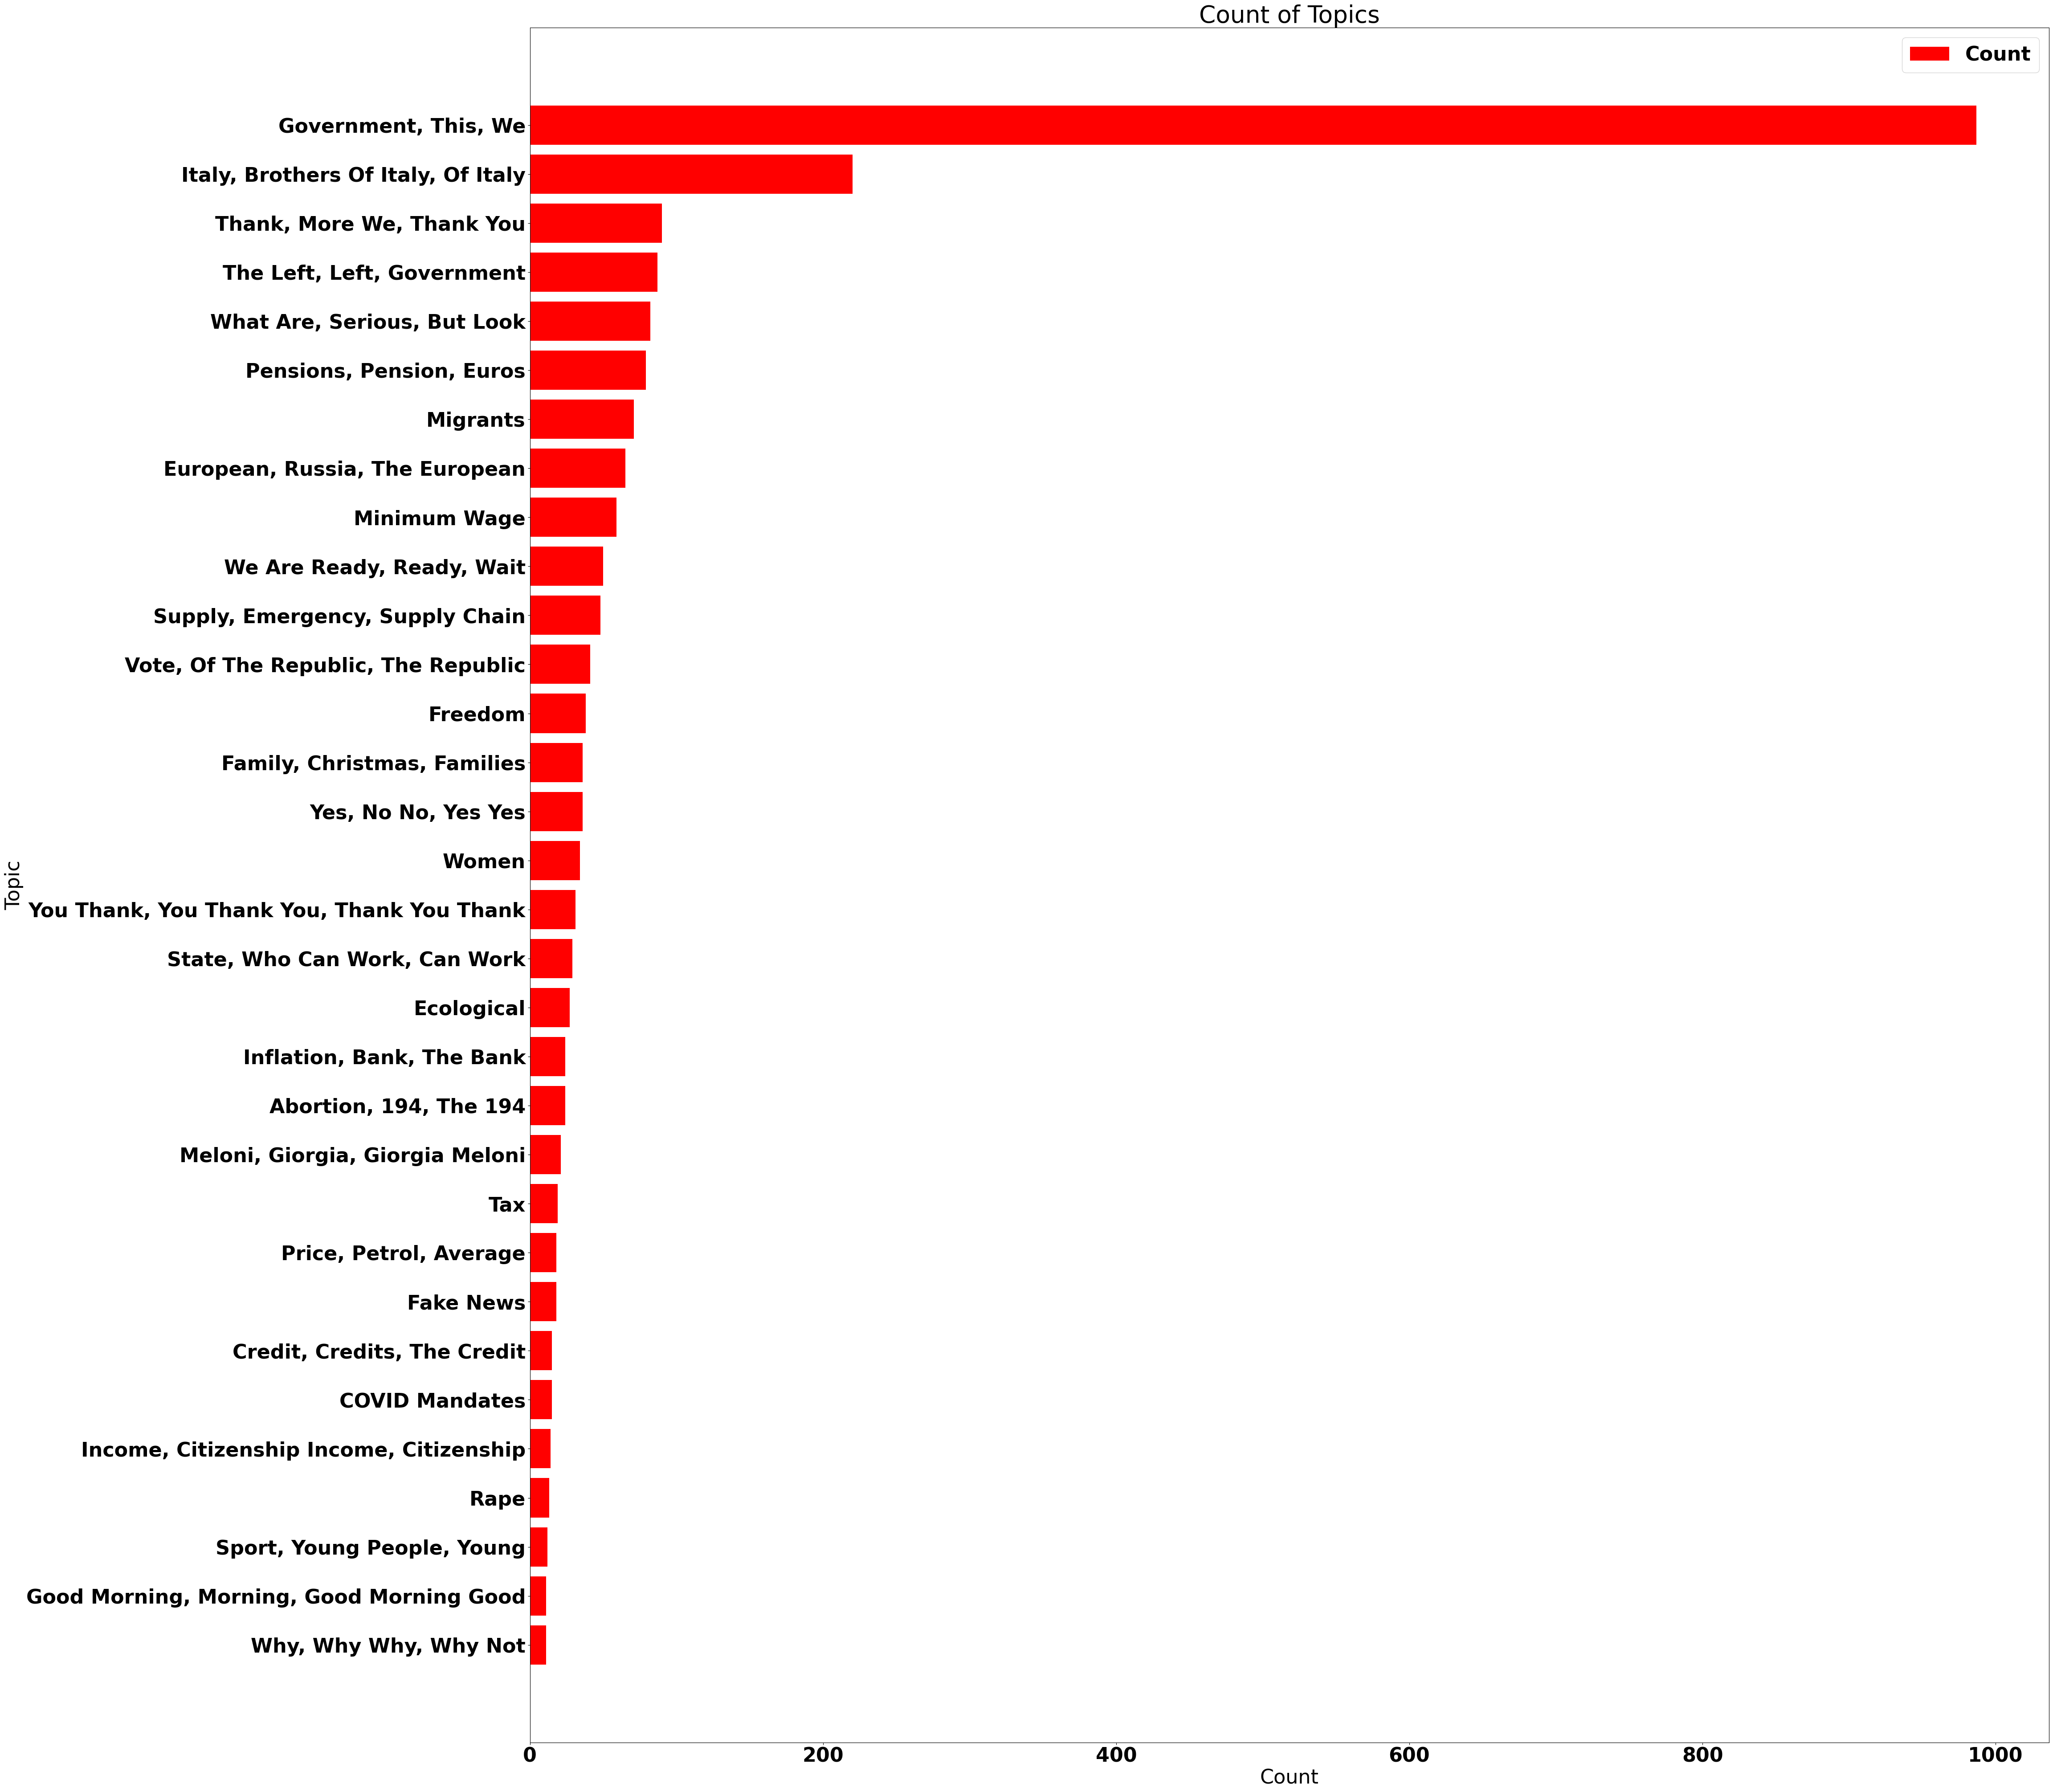

In [14]:
plt_df = topic_model.get_topic_info()
# plt_df = plt_df.drop([0])
plt_df = plt_df.sort_values(by='Count', ascending=True)

f = plt.figure()
f.set_figwidth(44)
f.set_figheight(50)
plt.barh(plt_df['CustomName'], plt_df['Count'], label = "Count", color='red')
font = {'weight' : 'bold',
        'size'   : 32}
plt.rc('font', **font)

plt.title('Count of Topics')
plt.xlabel('Count')
plt.ylabel('Topic')

plt.legend()
plt.savefig(processed_dir + 'images/topic-document-counts.png')
plt.show()

Show the documents in a particular topic

In [558]:
fig = topic_model.visualize_barchart(width=280, height=330, top_n_topics=60, n_words=10, custom_labels=True)
fig.write_html(processed_dir + 'html/topic-word-scores.html')
fig

## Documents in 'Migrants' Topic

In [539]:
representative_docs = topic_model.get_representative_docs(3)
representative_docs

df = pd.DataFrame({'Topic': topics, 'document': docs})
df[df['Topic'] == 3].head(50)

,Topic,document
19,3,"We have begun to defend our borders from human traffickers, from support for Ukraine to the Mattei plan for Africa, through over sixty contacts and meetings with the leaders of as many nations."
77,3,What are the measures?
134,3,It's mostly women.
260,3,"and it's time colleagues to call some things by their name, recognize the refugee status of those fleeing from Ukraine, mothers and children who are actually fleeing from the war and perhaps take advantage at the same time to repatriate those who are here."
261,3,"But refugees are not about welcoming a community, giving hospitality to a community that in Italy sees many integrated people, respectful of our rules."
265,3,"You see, President, when there is a war it is the women and children who flee, the men tend to stay and fight."
266,3,And I say this because for years here we have been told that there was the tragedy of refugees faced with images of boats full of single men of working age.
267,3,"The images of these hours are a boulder on certain lies and coincidentally, faced with a clear distinction between refugees and economic migrants."
268,3,Which First Nations provide assistance?
278,3,"The decree provides for an increase in penalties for migrant trafficking, but above all provides for the introduction of a new type of crime relating to death or serious injuries, as a consequence of trafficking of illegal immigrants which provides for these criminals to be punished with a penalty up to thirty years of imprisonment."


## Topic Frequency

In [560]:
df_topic_freq = topic_model.get_topic_freq()
topics_count = len(df_topic_freq) - 1
df_topic_freq

,Topic,Count
0,-1,1150
4,0,193
6,1,133
11,2,114
7,3,93
1,4,82
13,5,57
5,6,48
20,7,44
18,8,37


In [573]:

# remove outliers
#  Comment out this line below if you decided to use the "propbabilities" strategy
# new_topics = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf")

# Reduce outliers using the `probabilities` strategy (Uncomment to use this)



,Topic,Count,Name,Representation,Representative_Docs
0,0,412,0_italy_brothers of italy_italian_of italy,"[italy, brothers of italy, italian, of italy, brothers, brothers of, in italy, italians, government, the italian]","[precisely on the employment front there is some good news, the latest Bank of Italy report, Ministry of Labor Anpal tells us that between January and February two thousand and twenty-three, that is, January and February of this year, despite the difficult moment that Europe and obviously Italy face, there are Over one hundred thousand new jobs have been created in Italy, an increase more than double that of the first two months of the previous year and about a third greater than the same months of 2019, i.e., The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on this, I move forward and I believe that this is what Italians expect from me and from the government currently in office, This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces.]"
1,1,332,1_government_vote_me_not,"[government, vote, me, not, it, the government, political, this, they, the left]","[They say because we didn't want to enter into the government's competences, let's say it seems a bit more like a game of craps to me, as if to say in our opinion it should be done, but then you see it for yourself, then serious things from this point of view are done with roofing., But look, if I had presented myself with a structured counter-proposal from the government it would have been said that I didn't want to allow the opposition to do theirs, just as when I proposed to make a comparison with in I was accused of wanting to make the opposition withdraw the proposal., We will increase the resources and equipment of the police forces, we will relaunch and strengthen the operation, safe streets, we will increase video surveillance where necessary, we will redevelop the suburbs, especially the most degraded ones, because from the redemption of those areas and the people who live there well-being and safety also pass through and therefore we will encourage the opening of businesses in those areas, especially in the evening hours.]"
2,2,251,2_thank_will_you_day,"[thank, will, you, day, here, our, we will, your, home, we]","[In short, it seems to me that it cannot be said that like everyone else I have not done my best to do my job, as is right and normal because my job is to try to solve problems and it is that resignation of plants Tosi opposition asks for the resignation of a different minister every day, so you understand that it is no longer much news., We also thank the acting general and the military forces who intervened, all the civil protection, all the rescuers, the volunteers and obviously we continue and return to express our solidarity with the families affected, the families of the victims, the families of the missing, the their gravitation and

In [534]:
fig = topic_model.visualize_topics(custom_labels=True)
fig.write_html(processed_dir + 'html/inter-topic-distance-map.html')
fig

## Visualise Topics

## Topics over time 

Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps.

In [535]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)
# intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, topics=interesting_topics, custom_labels=True)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, custom_labels=True)

intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

166it [48:36, 17.57s/it]


In [536]:
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# embeddings = sentence_model.encode(docs, show_progress_bar=False)
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# This is a way of summarising the document using the original caption in a way to group the sentence
# could also use date
# adjusted_docs = ["<b>" + title + "</b><br>" + doc[:100] + "..." 
#                  for doc, title in zip(docs, titles)]
# documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True, adjusted_docs=adjusted_docs)

documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True)
documents_and_topics_fig.write_html(processed_dir + 'html/documents-and-topics.html')
documents_and_topics_fig

In [426]:
doc_id = 41
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id], custom_labels=True)

100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


TypeError: BERTopic.visualize_approximate_distribution() got an unexpected keyword argument 'custom_labels'

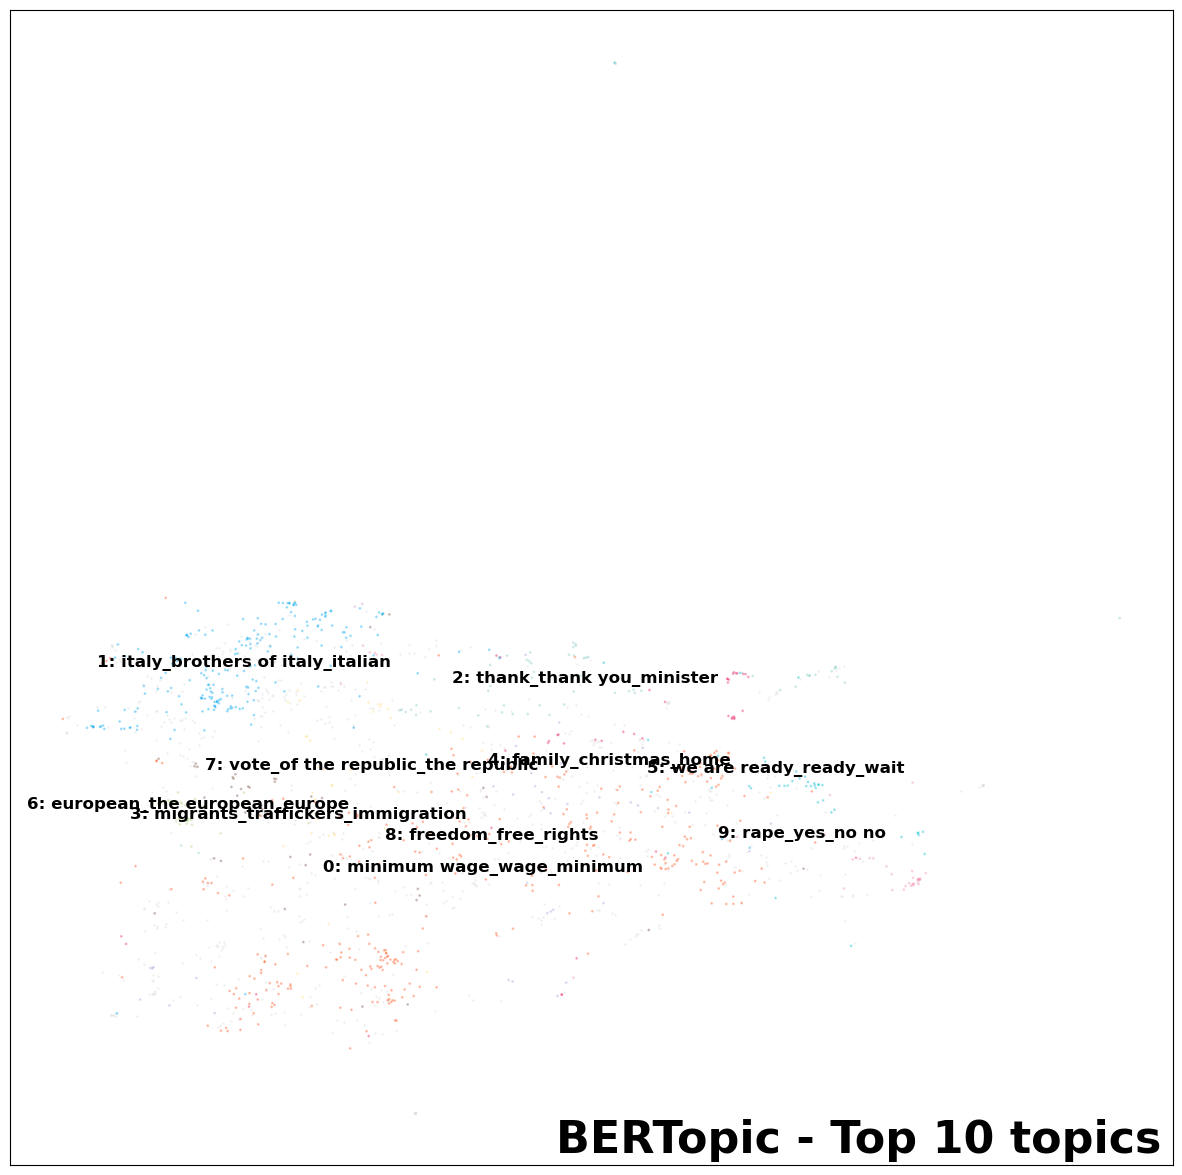

In [427]:

# Prepare data for plotting
embeddings = topic_model._extract_embeddings(docs, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics

# Plot parameters
top_n = 10
fontsize = 12

# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                         '#03A9F4', # Blue
                                         '#4CAF50', # Green
                                         '#80CBC4', # FFEB3B
                                         '#673AB7', # Purple
                                         '#795548', # Brown
                                         '#E91E63', # Pink
                                         '#212121', # Black
                                         '#00BCD4', # Light Blue
                                         '#CDDC39', # Yellow/Red
                                         '#AED581', # Light Green
                                         '#FFE082', # Light Orange
                                         '#BCAAA4', # Light Brown
                                         '#B39DDB', # Light Purple
                                         '#F48FB1', # Light Pink
                                         ])

# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
    topic = int(row[1].topic)
    text = f"{topic}: " + "_".join([x[0] for x in topic_model.get_topic(topic)[:3]])
    ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [ ]:
topic_model.hierarchical_topics(docs)

# semi supervised topics model
# topic_model.fit(docs, y = y)

# incremental topic modelling
# topic_model.partial_fit(docs)

# Dynamci topics topics over time
# topic_model.topics_over_time(docs, timestamps=)

# class based topic modelling
# topic_model.topics_per_class(docs, classes)
The stop word vec taht does nto work.
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
topic_model.get_topic_info().head(50)

## Analyse Individual Topics 

In [ ]:
topic_model.get_topic(11, full=True)